In [16]:
pip install --quiet torchdyn==1.0.6  torchdiffeq

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import MultivariateNormal
from sklearn.datasets import make_moons
import seaborn as sns
import matplotlib.animation as animation

# TorchDyn ≥ 1.0 – current API
from torchdyn.models import CNF           # Continuous Normalising Flow
from torchdyn.models.cnf import hutch_trace    # Hutchinson estimator
from torchdyn.core import NeuralODE       # ODE solver wrapper

# Torch settings
torch.set_default_dtype(torch.float32)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from IPython.display import Image, display

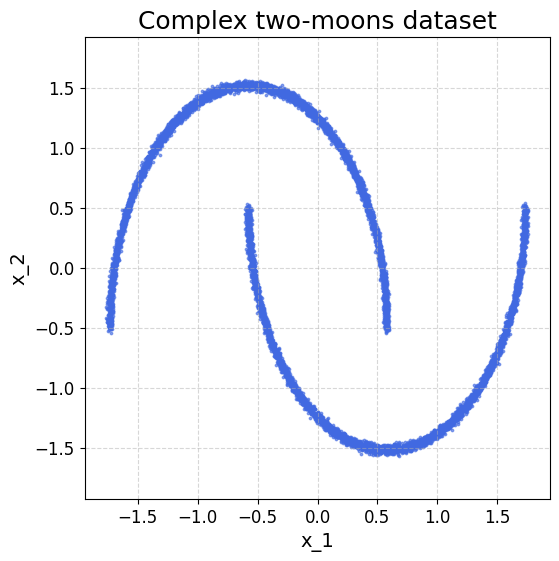

In [18]:
def generate_two_moons(n=10_000, noise=0.01):
    x, _ = make_moons(n_samples=n, noise=noise)
    x = (x - x.mean(0)) / x.std(0)        # standardise each coordinate
    return torch.from_numpy(x).float()

x = generate_two_moons().to(device)
dataset = TensorDataset(x)
loader  = DataLoader(dataset, batch_size=256, shuffle=True)

plt.figure(figsize=(6, 6))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), s=3, alpha=0.6, color='royalblue')

plt.title("Complex two-moons dataset", fontsize=18)
plt.xlabel("x_1", fontsize=14)
plt.ylabel("x_2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [19]:
class MLP(nn.Module):
    """3-layer MLP without an explicit time input (TorchDyn will pass only x)."""
    def __init__(self, dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64), nn.Softplus(),
            nn.Linear(64, 64),   nn.Softplus(),
            nn.Linear(64, 64),   nn.Softplus(),
            nn.Linear(64, dim)
        )

    # <--  only 'x' (and the optional **args TorchDyn may send)
    def forward(self, x, args=None):
        return self.net(x)

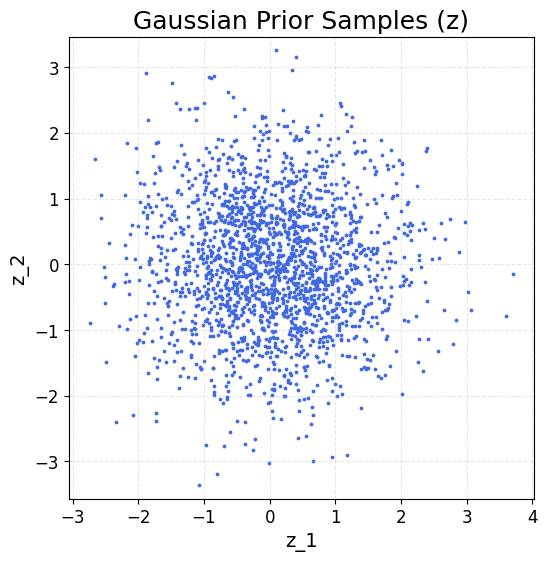

In [20]:
# Sample 'z' from the prior distribution (Standard Normal)
# We generate 2000 points, similar to your 'n_vis' in the notebook
prior  = MultivariateNormal(torch.zeros(2, device=device), torch.eye(2, device=device))
with torch.no_grad():
    z_samples = prior.sample((2000,))

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.scatter(z_samples[:, 0].cpu(), z_samples[:, 1].cpu(), s=3, c='royalblue')
    plt.title("Gaussian Prior Samples (z)", fontsize=18)
    plt.xlabel("z_1", fontsize=14)
    plt.ylabel("z_2", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Optional: Add grid and keep aspect ratio square
    plt.axis('equal')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.show()

In [22]:
vf     = MLP(dim=2)
cnf    = CNF(vf, trace_estimator=hutch_trace, noise_dist=MultivariateNormal(torch.zeros(2), torch.eye(2)))
p = MultivariateNormal(torch.zeros(2,  device=device), torch.eye(2,     device=device))
cnf = CNF(vf,trace_estimator=hutch_trace, noise_dist=p).to(device)           # keep CNF itself on GPU
node   = NeuralODE(cnf, solver='dopri5', atol=1e-4, rtol=1e-4, sensitivity='adjoint', return_t_eval=False).to(device)
opt    = torch.optim.AdamW(node.parameters(), lr=2e-3, weight_decay=1e-5)
n_epoch = 250
loss_history = []

for epoch in range(1, n_epoch + 1):
    running_loss = 0.
    for (batch_x,) in loader:
        batch_x = batch_x.to(device)

        # prepend a zero column ⇒ shape (B, 1 + d); 1st dim = divergence accumulator
        z0 = torch.cat([torch.zeros(batch_x.size(0), 1, device=device), batch_x], dim=1) # concatenate along column,
        # column of zeros(batch size,1)
        # You concatenate the zeros column (B, 1) as the first column, and then the data batch_x (B, d) as the remaining columns
        # Resulting shape is (B, 1 + d).

        zT = node(z0)
        if isinstance(zT, tuple):                     # TorchDyn can return (y, t_eval)
            zT, _ = zT                                 # shape (T, B, 3) or (T, B, D), node(z0) means: numerically solve z = f(t,z) with z(t0)=x0 and return z(t1).
        if zT.dim() == 3:
            zT = zT[-1] # Shape is [Time, Batch, Dim], take last Time
        else:
            pass # Shape is already [Batch, Dim], do nothing

        log_p_z = prior.log_prob(zT[:, 1:])
        # Integral of Trace term
        trace_integral = zT[:, 0]
        # The complete Change of Variables formula:
        log_p_x = log_p_z - trace_integral
        # Maximize likelihood == Minimize Negative Log Likelihood
        loss = -log_p_x.mean()

        opt.zero_grad()

        #find gradient of loss- loss.backward()
        loss.backward()
        opt.step()

        running_loss += loss.item() * batch_x.size(0)

    avg_nll = running_loss / len(loader.dataset)
    loss_history.append(avg_nll)  # <--- Store the loss

    if epoch % 10 == 0:
        avg_nll = running_loss / len(loader.dataset)
        print(f"epoch {epoch:02d} | NLL {avg_nll:8.5f}")

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
epoch 10 | NLL  1.89759
epoch 20 | NLL  1.41060
epoch 30 | NLL  1.00268
epoch 40 | NLL  0.59332
epoch 50 | NLL  0.51119
epoch 60 | NLL  0.18372
epoch 70 | NLL  0.10191
epoch 80 | NLL  0.22472
epoch 90 | NLL  0.09337
epoch 100 | NLL  0.00434
epoch 110 | NLL  0.11244
epoch 120 | NLL -0.01658
epoch 130 | NLL -0.04788
epoch 140 | NLL  0.17349
epoch 150 | NLL  0.00264
epoch 160 | NLL -0.06820
epoch 170 | NLL -0.04237
epoch 180 | NLL  0.07012
epoch 190 | NLL -0.07673
epoch 200 | NLL -0.09931
epoch 210 | NLL -0.01084
epoch 220 | NLL -0.20310
epoch 230 | NLL  0.00892
epoch 240 | NLL -0.16233
epoch 250 | NLL -0.16907


Time: 30 mins approx
Epoch 250

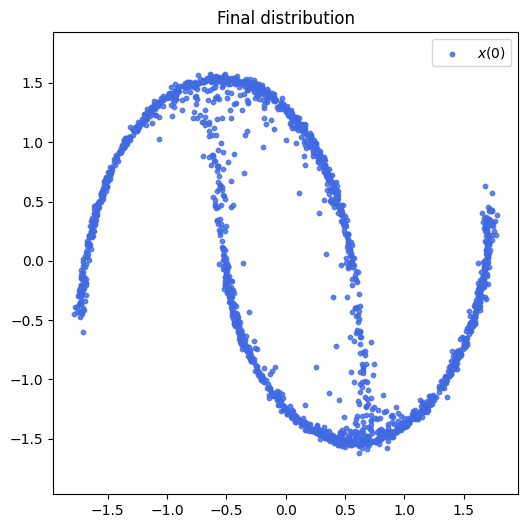

In [40]:
with torch.no_grad():
    n_vis   = 2_000
    z_prior = prior.sample((16_384,)).to(device)
    z0      = torch.cat([torch.zeros(z_prior.size(0), 1, device=device), z_prior], 1)

    t_span  = torch.tensor([1., 0.], device=device)        # just endpoints
    traj    = node.trajectory(z0, t_span)                  # shape (2, B, 3)
    xT      = traj[-1, :, 1:].cpu()                        # final data sample

# ─── plot ─────────────────────────────────────────────────────────
plt.figure(figsize=(6, 6))

#plt.scatter(z_prior[:n_vis, 0].cpu(), z_prior[:n_vis, 1].cpu(),
            #s=10, c='k', alpha=.8, label=r'$z\sim\mathcal{N}(0,I)$')

plt.scatter(xT[:n_vis, 0], xT[:n_vis, 1],
            s=10, c='royalblue', alpha=.8, label=r'$x(0)$')

plt.legend()
plt.axis('equal')
plt.title("Final distribution")
plt.show()

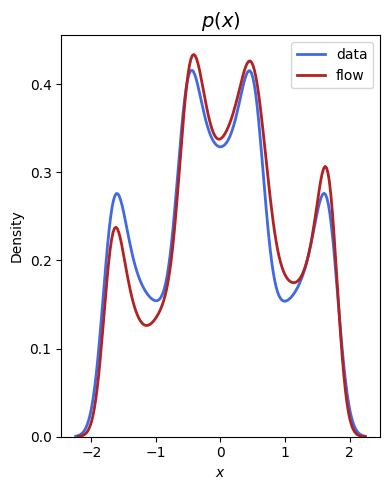

In [25]:
x_data  = x[:, 0].cpu().numpy()         # first coordinate
x_model = xT[:, 0].cpu().numpy()      # or nf_sample[:, 0]

plt.figure(figsize=(4, 5))
sns.kdeplot(x=x_data,  label='data',  color='royalblue', linewidth=2)
sns.kdeplot(x=x_model, label='flow',  color='firebrick', linewidth=2)
plt.title(r"$p(x)$", fontsize=14)
plt.xlabel(r"$x$")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

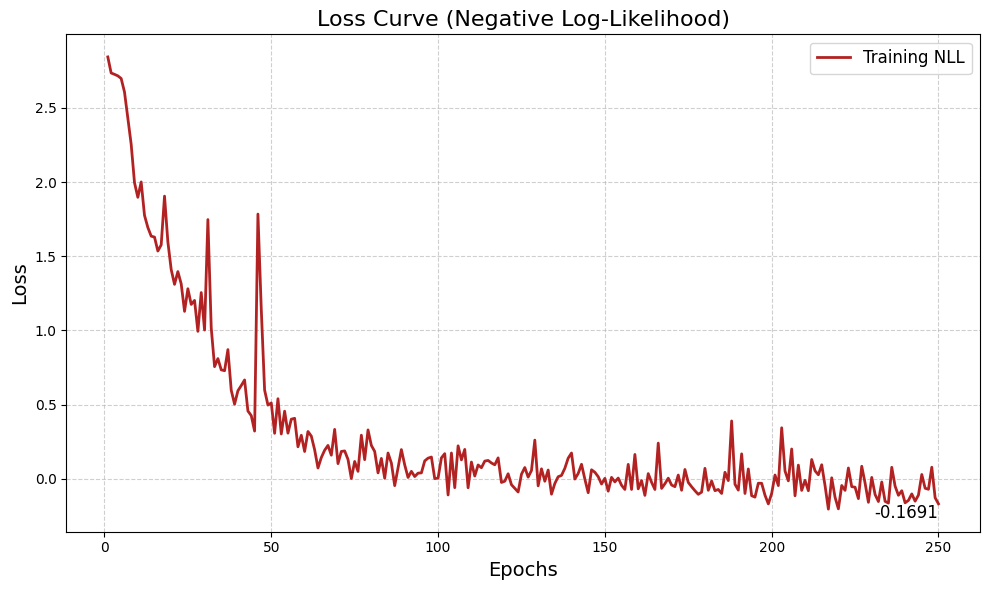

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epoch + 1), loss_history, color='firebrick', linewidth=2, label='Training NLL')

plt.title("Loss Curve (Negative Log-Likelihood)", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.text(n_epoch, loss_history[-1], f"{loss_history[-1]:.4f}",
         fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.tight_layout()
plt.show()

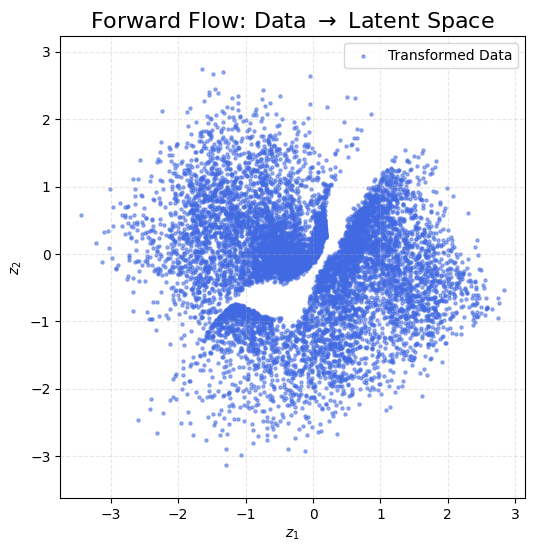

In [35]:
# 1. Get real data
real_data = x.to(device) # Shape [Batch, 2]

# 2. Augment
z0_data = torch.cat([torch.zeros(real_data.shape[0], 1).to(device), real_data], 1)

# 3. Pass forward (Data -> Noise)
with torch.no_grad():
    zT_data = node(z0_data)
    if zT_data.dim() == 3:
        zT_data = zT_data[-1]

    # Extract just the coordinates (ignore trace column)
    latents = zT_data[:, 1:].cpu().numpy()

# 4. Plot
plt.figure(figsize=(6, 6))
plt.scatter(latents[:, 0], latents[:, 1], s=5, color='royalblue', alpha=0.5, label='Transformed Data')
plt.title("Forward Flow: Data $\\to$ Latent Space", fontsize=16)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

Animation saved as scatter.gif


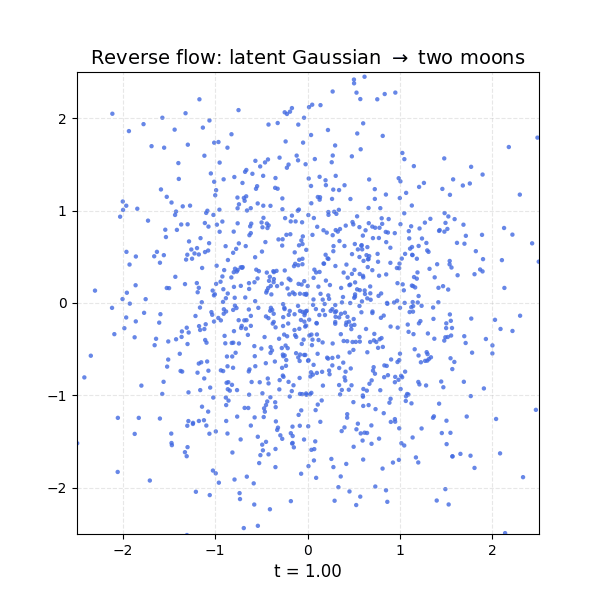

In [39]:
# 1. Configuration
N_ANIM_SAMPLES = 1024
N_FRAMES = 100  # Number of frames in the GIF

# 2. Sample Latent Points (Gaussian Prior)
# We generate random noise z ~ N(0, I)
z_prior_anim = prior.sample((N_ANIM_SAMPLES,)).to(device)

# 3. Augment with Zeros (for CNF compatibility)
# Shape becomes [N_ANIM_SAMPLES, Dim + 1]
z0_anim = torch.cat([torch.zeros(z_prior_anim.shape[0], 1).to(device), z_prior_anim], 1)

# 4. Integrate Backward (Latent t=1 -> Data t=0)
# We define time points to save. Linspace from 1.0 down to 0.0
t_span = torch.linspace(1.0, 0.0, N_FRAMES + 1).to(device)

# Solves the ODE and returns the state at every time step in t_span
# Output shape: [N_FRAMES + 1, N_ANIM_SAMPLES, Dim + 1]
with torch.no_grad():
    trajectory = node.trajectory(z0_anim, t_span)

# 5. Prepare Data for Animation (Convert to NumPy)
# We need [Time, Particles, 2] (just x,y coordinates, ignoring trace column 0)
trajectory_numpy = trajectory[:, :, 1:].cpu().numpy()
t_span_numpy = t_span.cpu().numpy()

# 6. Create Animation
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Reverse flow: latent Gaussian $\\to$ two moons", fontsize=14)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect("equal")
ax.grid(True, linestyle='--', alpha=0.3)

# Initialize scatter plot with the first frame (t=1.0)
scat = ax.scatter(trajectory_numpy[0, :, 0], trajectory_numpy[0, :, 1],
                  s=10, c="royalblue", alpha=0.8, edgecolors='none')

def animate(i):
    # Update particle positions for frame i
    data = trajectory_numpy[i]
    scat.set_offsets(data)

    # Update time label
    t_current = t_span_numpy[i]
    ax.set_xlabel(f"t = {t_current:.2f}", fontsize=12)
    return scat,

# Create animation object
ani = animation.FuncAnimation(fig, animate, frames=len(t_span),
                              interval=50, blit=True)

# Save
ani.save("scatter.gif", dpi=100, writer=animation.PillowWriter(fps=20))
plt.close(fig)

print("Animation saved as scatter.gif")
Image(filename="scatter.gif")